# HarvestStat Data Profiling - Angola

In [1]:
import glob, json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Load FEWS NET administrative boundaries ------- #
epsg = 'EPSG:32733'
fn_shapes = sorted(glob.glob('../data/shapefile/fewsnet/AO_Admin?_????.shp'))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# FDW API host address -------------------------- #
host = 'https://fdw.fews.net'
parameters = {
    'format': 'json',
    'country': 'Angola',
    'product': ['R011','R012','R013','R014','R015','R016','R017','R018','R019'],
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint,params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df_origin = df.copy()
# ----------------------------------------------- #

- FEWS NET admin shapefiles ------------------- #
| year	 | Admin1   | # units   | Admin2   | # units   | Admin3   | # units   |
| 2008	 | AO2008A1 | 18	| AO2008A2	| 160	| nan	| 0	|
----------------------------------------------- #


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority="Area Planted")
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([AO_Admin1_2008], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 14,468
Removed 1,041 "Missing Value" points
2,732/3,617 "Area Harvested" points are retained.
3,576/3,617 "Area Planted" points are retained.
3,580/3,617 "Quantity Produced" points are retained.
3,539/3,617 "Yield" points are retained.
Current data points: 13,427

- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1997 - 2017
29 grain types are found: Avocado (unspecified), Banana (unspecified), Beans (mixed), Cabbage (Unspecified), Carrots, Cassava, Chili pepper (Unspecified), Coffee (unspecified), Cowpeas (Mixed), Garlic (dry), Green bean (fresh), Groundnuts (In Shell), Lemon (unspecified), Maize (Corn), Mango (unspecified), Melon (unspecified), Millet, Millet (Pearl), Okras (Fresh), Onions, Pineapple (unspecified), Potato (Irish), Rice (Paddy), Sorghum, Soybean (unspecified), Sweet Potatoes, Tomato, Watermelon, Wheat Grain
1 seasons are found: Main (

- Angola crop seasonal calendar

<img src="../figures/crop_calendar/seasonal-calendar-angola.png" width=900><br>

<img src="../figures/crop_calendar/safrica_ao_calendar.png" width=900>

- comparison of boundaries</br>

<img src="../figures/AO_admin_shapes.png" width=900>

- In Angola, basd on the FEWS NET data, there were zero times of changes in administrative units. We will use the 2008 administrative units

| year	 | Admin1   | # units   | Admin2   | # units   |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 2008	 | AO2008A1 | 18	| AO2008A2	| 160	|

- The data is all reported in a single `Main (02-01)` season
- The data is available at admin level 1

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 1
shape_latest = AO_Admin1_2008.copy().to_crs('epsg:32733')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
# Drop "Commercial (PS)" CPS and merge all CPSs into "All (PS)"
area_new, prod_new = FDW_PD_MergeCropProductionSystem(area, prod, cps_remove=['Commercial (PS)'], cps_final='All (PS)')
df['crop_production_system'] = 'All (PS)'
# ----------------------------------------------- #

In [5]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Manual change of product name
product_category_custom = {
    'Avocado (unspecified)': 'Avocado',
    'Banana (unspecified)': 'Banana',
    'Beans (mixed)': 'Beans (mixed)',
    'Cabbage (Unspecified)': 'Cabbage',
    'Carrots': 'Carrots',
    'Cassava': 'Cassava',
    'Chili pepper (Unspecified)': 'Chili pepper',
    'Coffee (unspecified)': 'Coffee',
    'Cowpeas (Mixed)': 'Cowpeas',
    'Garlic (dry)': 'Garlic',
    'Green bean (fresh)': 'Green bean',
    'Groundnuts (In Shell)': 'Groundnuts (In Shell)',
    'Lemon (unspecified)': 'Lemon',
    'Maize (Corn)': 'Maize',
    'Mango (unspecified)': 'Mango',
    'Millet': 'Millet',
    'Millet (Pearl)': 'Millet (Pearl)',
    'Okras (Fresh)': 'Okras',
    'Onions': 'Onions',
    'Pineapple (unspecified)': 'Pineapple',
    'Potato (Irish)': 'Potato',
    'Rice (Paddy)': 'Rice',
    'Sorghum': 'Sorghum',
    'Soybean (unspecified)': 'Soybean',
    'Sweet Potatoes': 'Sweet Potatoes',
    'Tomato': 'Tomato',
    'Wheat Grain': 'Wheat'
}
assert set(stack['product'].unique()) == set(product_category_custom.keys())
stack['product'] = stack['product'].replace(product_category_custom)
# Calibration of crop calendar using External Crop Calendar (ECC)
ecc = pd.read_csv('../data/crop_calendar/external_crop_calendar.csv')
ecc = ecc[ecc['country'] == 'Angola']
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, ecc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

# Save data
fn_out = '../data/crop/adm_crop_production_AO.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')

All [season_name, product, crop_production_system] are in the external crop calendar.
../data/crop/adm_crop_production_AO.csv is saved.


# Visualization of production data

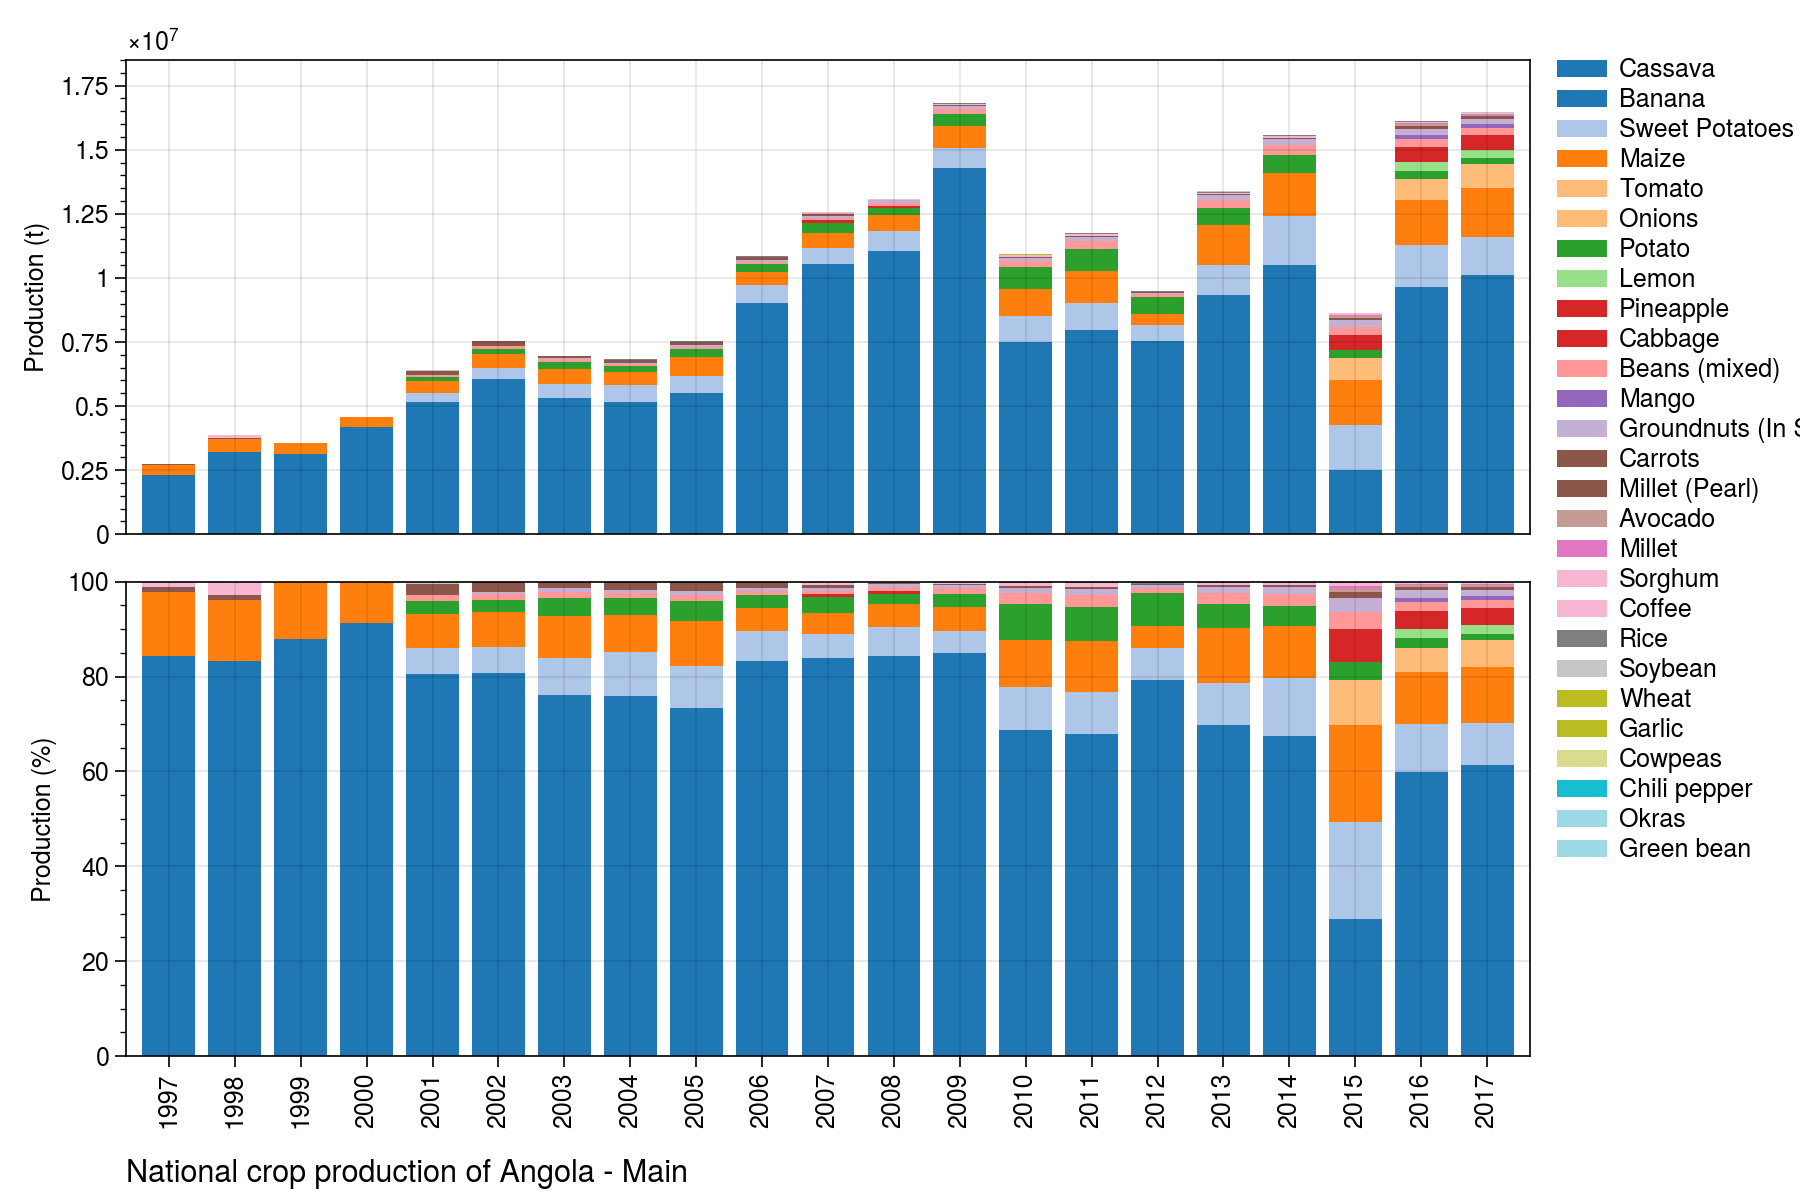

../figures/AO_bar_natgrainprod_Main.png is saved.


In [6]:
# Bar chart of national crop production
country_iso, country_name = 'AO', 'Angola'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

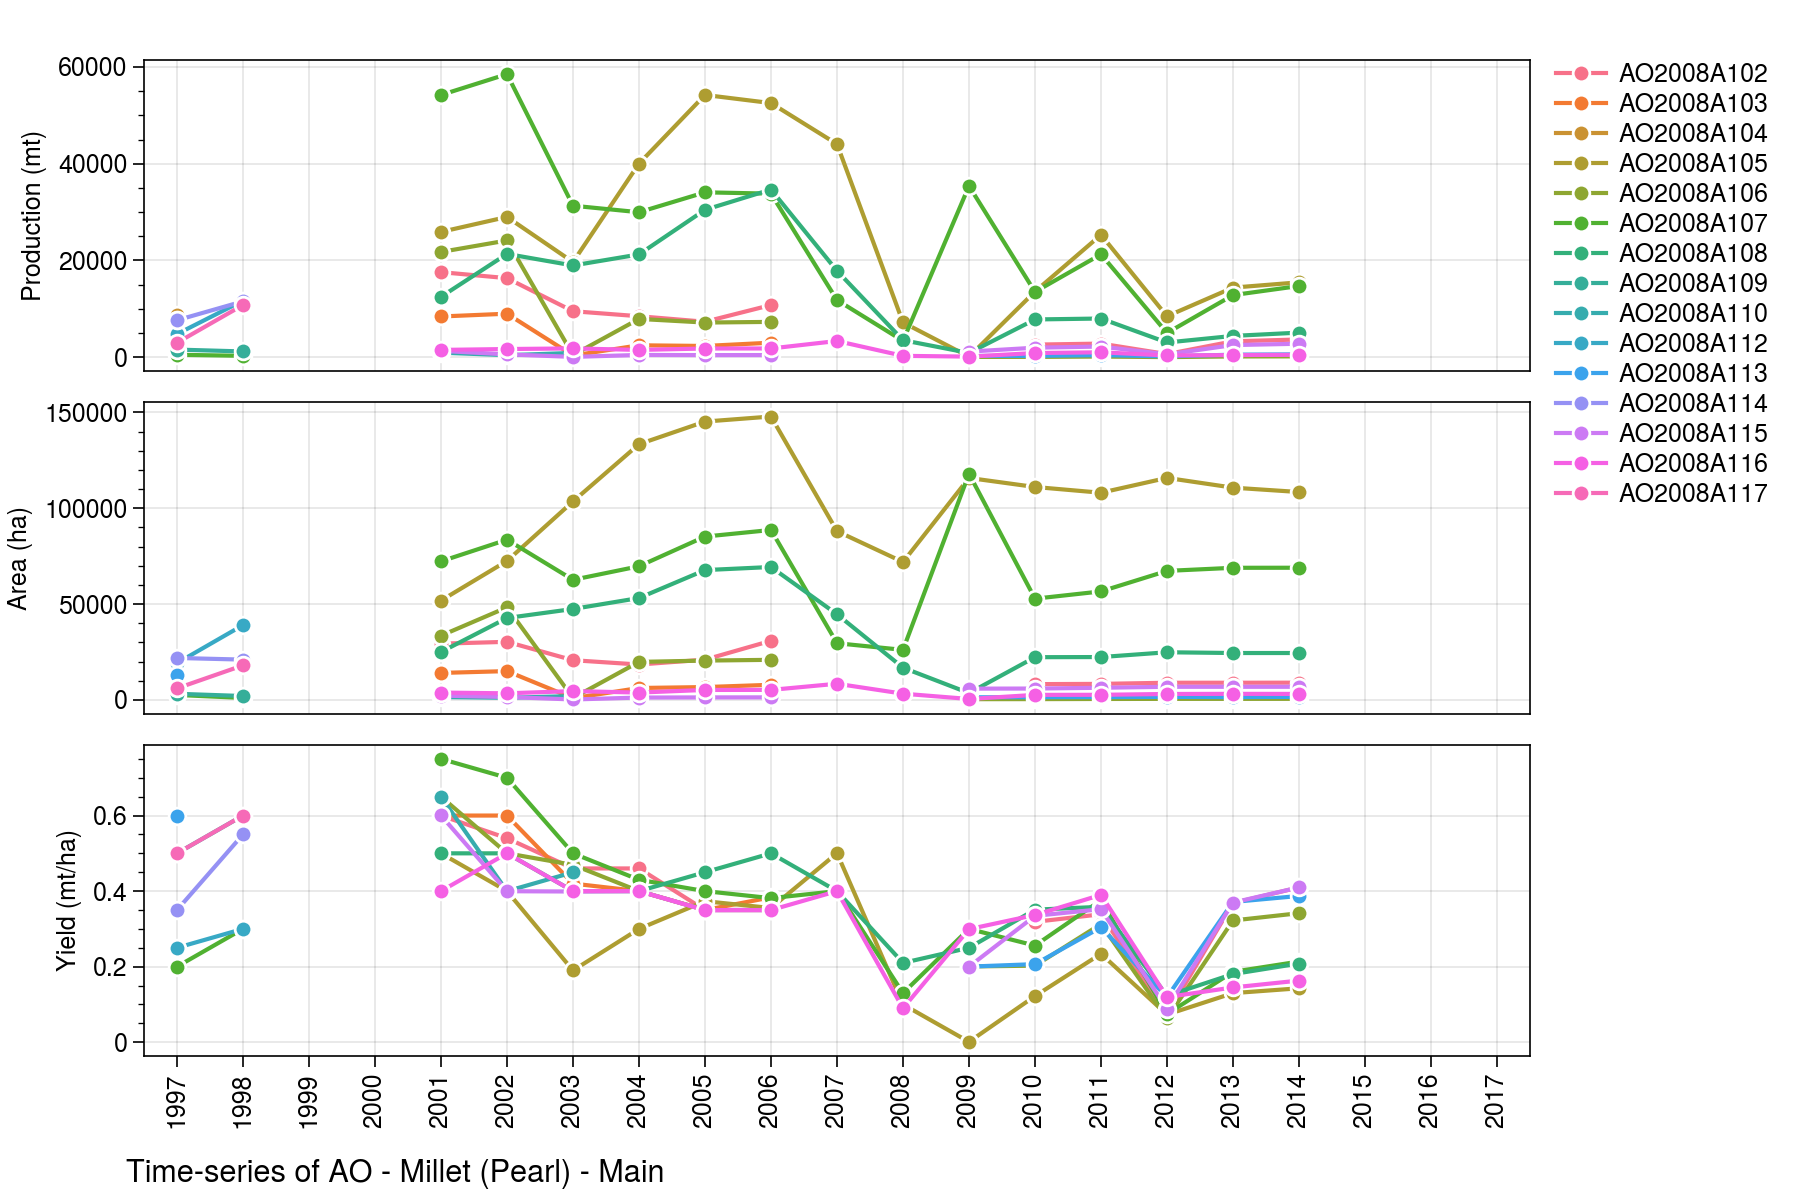

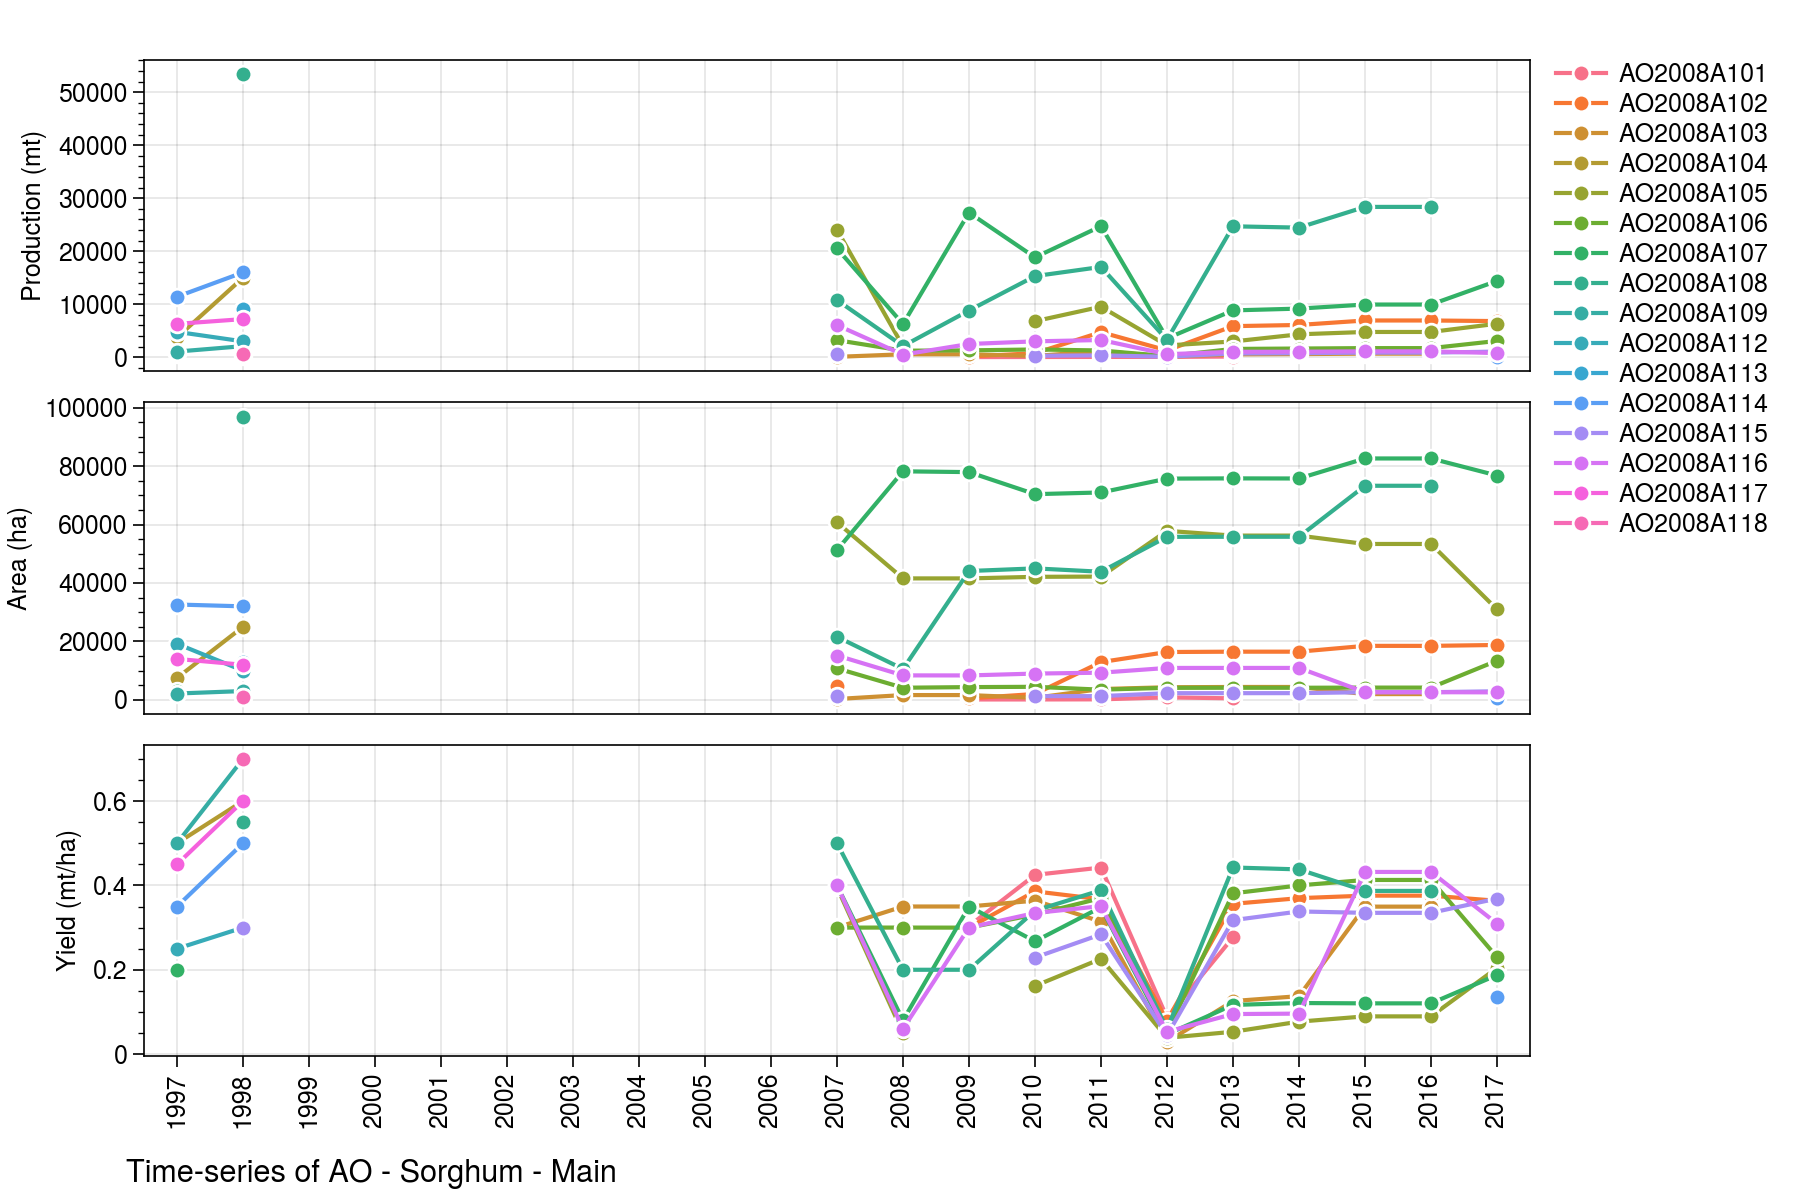

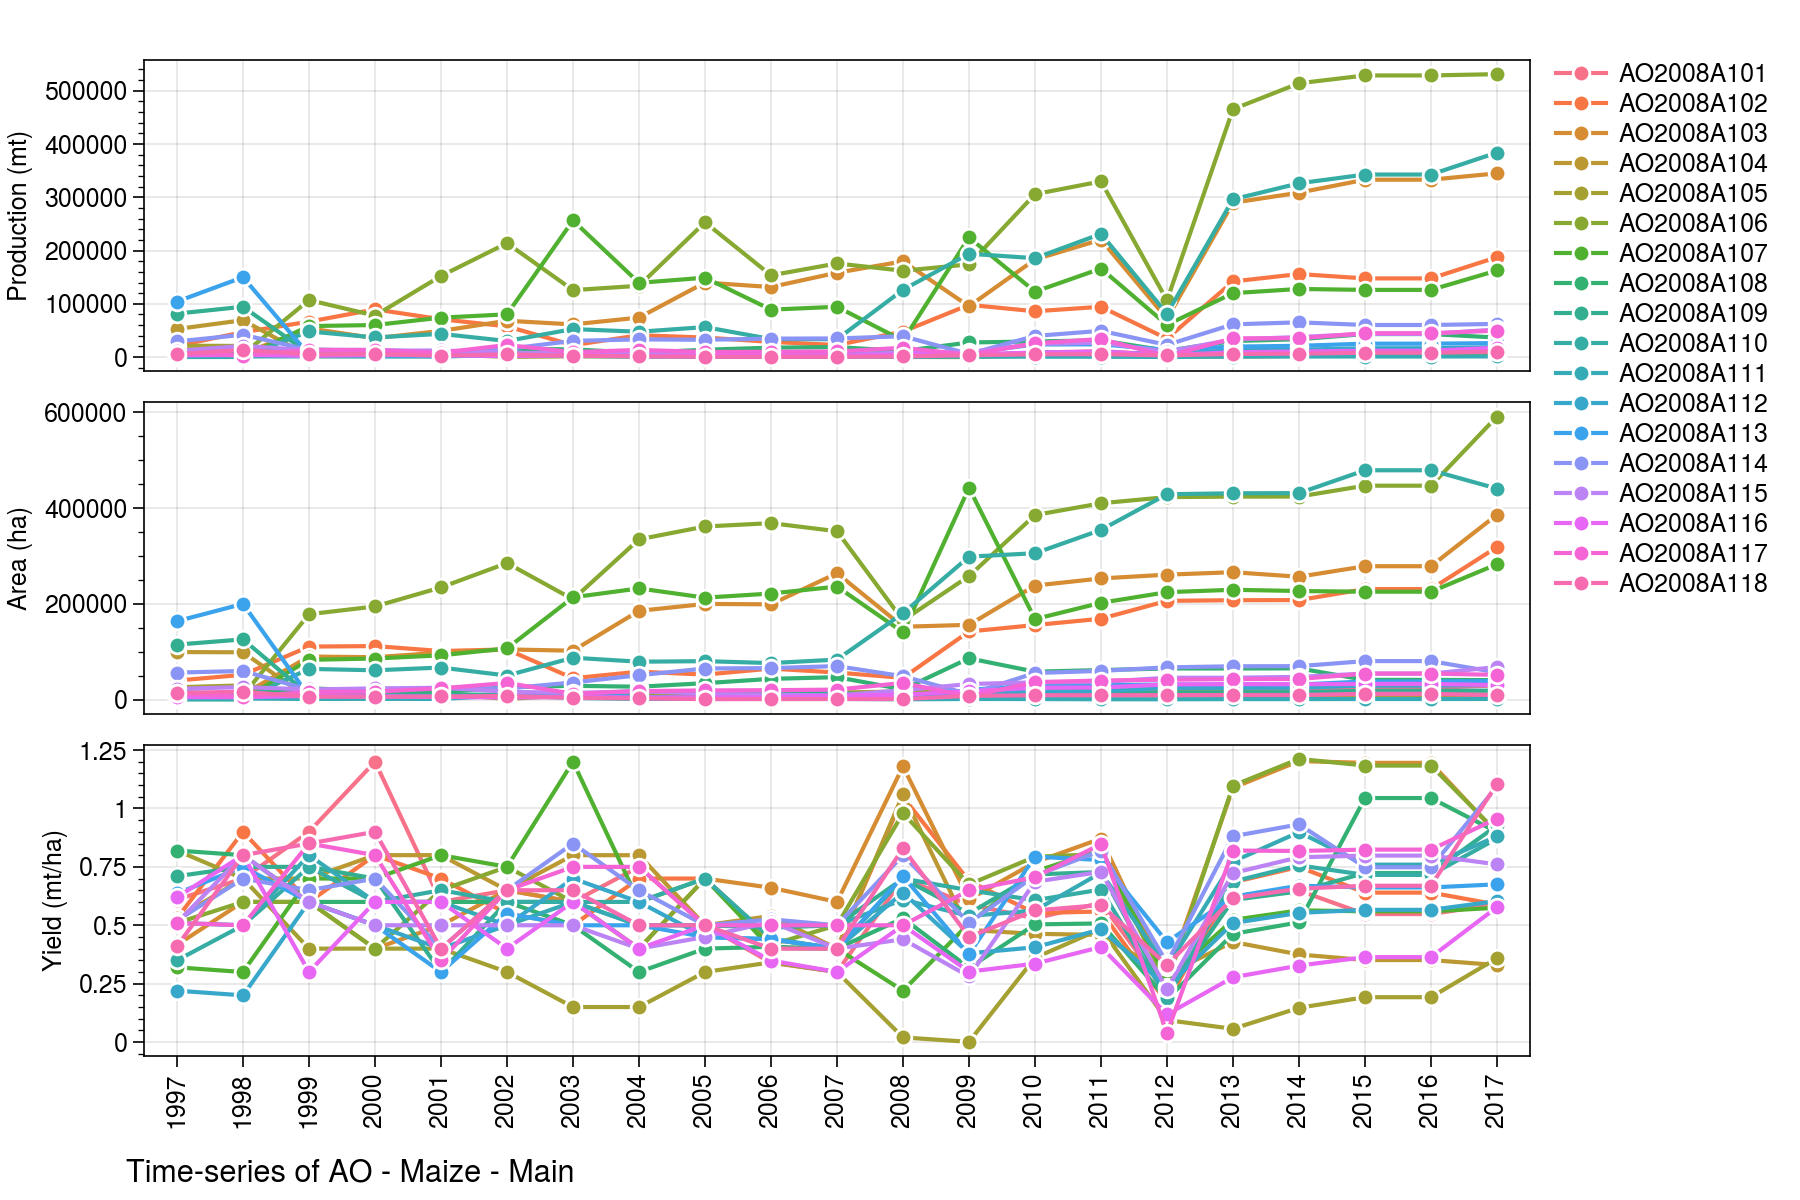

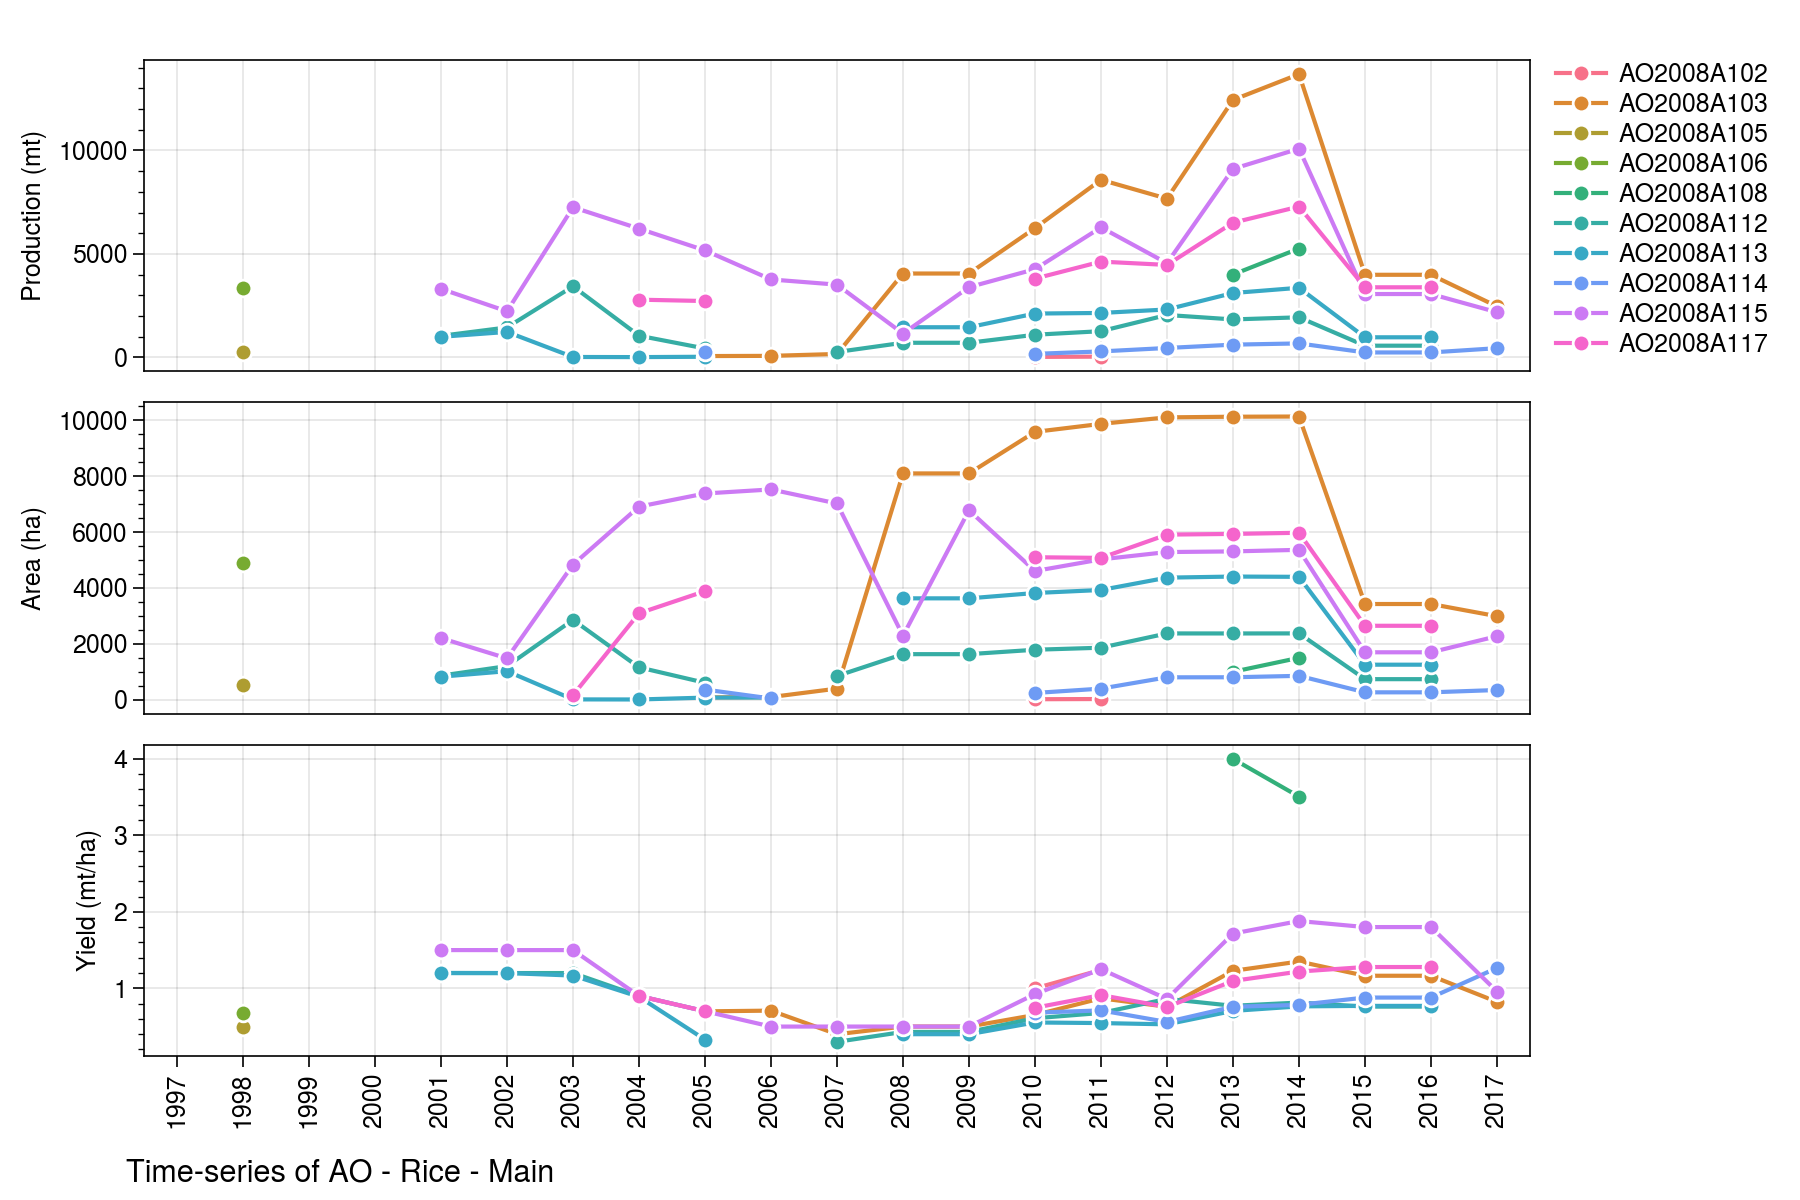

In [7]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'AO', 'Angola'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Millet (Pearl)','Main'],
    ['Sorghum','Main'],
    ['Maize','Main'],
    ['Rice','Main'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)